# Simple VEN for Capacity Management
- VEN process:
  - creates a subscription amount
  - creates a reservation amount
  - Send reservation to VTN 
  - Adjust subcription amount according to VTN prices 
  - Restart process
  - individual VENs are identified by resource name 

In [223]:
import random
import matplotlib.pyplot as plt
import requests
from time import sleep

class HomeLoad:
    def __init__(self, reservation_capacity=5, intervals=96):
        """
        Initialize the VEN with:
        - reservation_capacity: Maximum capacity the VEN is subscribed to.
        - intervals: Number of 15-minute intervals in a day (default 96).
        """
        self.reservation_capacity = reservation_capacity
        self.intervals = intervals
        self.base_load_shape = []  # Stores the base load shape for the day
        self.reservation_load_shape = []  # Stores the load shape with reservations

    def generate_random_load_shape(self):
        """
        Generate a random load shape where each interval load is between 0 and 4 kW.
        """
        self.base_load_shape = [random.uniform(0, self.reservation_capacity) for _ in range(self.intervals)]
        print("VEN: Generated random load shape for the day.")

    def generate_capacity_need(self):
        event_start = random.choice(range(0,19))
        # event can last from 1-4 hours 
        duration = random.choice(range(1,5))
        capacity = 5
        # if a price comes back, coin flip on if they want to pay it, todo later
        self.request_additional_capacity(event_start, event_start + duration, capacity)


    def request_additional_capacity(self, start_interval, end_interval, capacity):
        """
        Request additional capacity for a given range of intervals.
        
        Args:
        - start_interval (int): Start interval (1-indexed).
        - end_interval (int): End interval (1-indexed).
        - capacity (float or list): Additional capacity requested. 
          If a single value, it is applied to all intervals. If a list, it must match the range length.
        """
        # Ensure reservation_load_shape is initialized
        if not self.reservation_load_shape:
            self.reservation_load_shape = self.base_load_shape.copy()
        
        # Calculate the number of intervals in the range
        num_intervals = end_interval - start_interval + 1

        # Handle single capacity value for all intervals
        if isinstance(capacity, (int, float)):
            capacity_list = [capacity] * num_intervals
        # Handle list of varying capacity levels
        elif isinstance(capacity, list):
            if len(capacity) != num_intervals:
                raise ValueError(f"Capacity list length ({len(capacity)}) does not match the interval range ({num_intervals}).")
            capacity_list = capacity
        else:
            raise ValueError("Capacity must be either a single value or a list.")

        # Apply the additional capacity to the reservation load shape
        for i in range(start_interval - 1, end_interval):
            self.reservation_load_shape[i] += capacity_list[i - (start_interval - 1)]

        print(f"VEN: Requested additional capacity from interval {start_interval} to {end_interval}.")

    def plot_load_shapes(self):
        """
        Plot the base load shape and the load shape with reservations.
        """
        intervals = range(1, self.intervals + 1)
        plt.figure(figsize=(12, 6))
        plt.plot(intervals, self.base_load_shape, label="Base Load Shape", color="blue", linewidth=2)
        plt.plot(intervals, self.reservation_load_shape, label="Load Shape with Reservations", color="orange", linestyle="--", linewidth=2)
        plt.axhline(y=self.reservation_capacity, color="red", linestyle=":", label="Reservation Limit")
        plt.title("VEN Load Shape and Reservations", fontsize=14)
        plt.xlabel("Interval (15 minutes each)", fontsize=12)
        plt.ylabel("Load (kW)", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 8 to 10.


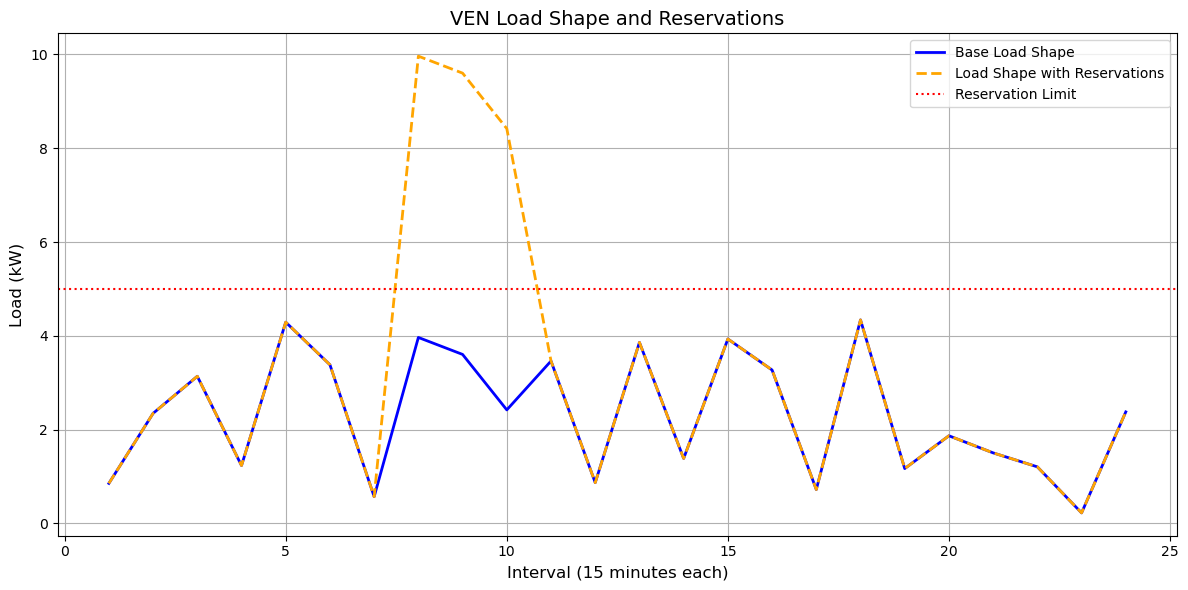

In [224]:
# Simulation
ven = HomeLoad(intervals = 24)

# Generate a random load shape for the day
ven.generate_random_load_shape()

# Request additional capacity
# Example 1: Single capacity level for the range
ven.request_additional_capacity(start_interval=8, end_interval=10, capacity=6)

# # Example 2: Varying capacities for the range
# ven.request_additional_capacity(start_interval=40, end_interval=44, capacity=[1, 2, 1.5, 3, 2.5])

# Plot the load shapes
ven.plot_load_shapes()

In [225]:
import requests
import json
from datetime import datetime, timedelta
# assuming 1 hour duration intervals
# not sure based on examples what the format of times should be
# may need to convert the time so that its format is always 2 digits, like 01 rather than 1
# kWh is used in the capacity request example, but doesn't make sense to me so using kW instead
HEADERS = {
            "Content-Type": "application/json",
            "Authorization": "Bearer ven_token"
        }

class CapacityAPIInterface:
    def __init__(self, api_url, client_name):
        """
        Initialize the API interface with the base API URL.
        
        Args:
        - api_url (str): The URL of the REST API endpoint to communicate with.
        """
        self.api_url = api_url
        self.client_name = client_name
    
    def get_capacity_event(self):
        r = requests.get("http://localhost:8080/openadr3/3.0.1/events", headers = HEADERS)
        # Should log the ID 
        return r

    def post_capacity_request(self, program_id, event_id, intervals):
        """
        Post a capacity request event to the REST API.
        
        Args:
        - program_id (str): The ID of the program.
        - event_id (str): The event ID.
        - intervals (list): List of intervals (start, duration). capacity_request_values (list): List of capacity values for each interval.
        
        Returns:
        - Response object from the POST request.
        """
        
        intervals_payload = []
        for i, interval in enumerate(intervals):
            interval_payload = {
                "id": i,
                "payloads": [{
                    "type": "IMPORT_CAPACITY_RESERVATION",
                    "values": [interval[1]]
                }]
            }
            intervals_payload.append(interval_payload)

        payload = {
            "reportName": "capacityReservationReport",
            "programID": program_id,
            "eventID": event_id,
            "clientName": self.client_name,
            "payloadDescriptors": [{
                "payloadType": "IMPORT_CAPACITY_RESERVATION",
                "units": "KW" # KWH originally
                }],
            "resources": [{
            "resourceName": "Resource_1",
            "intervalPeriod": {
                "start": f"2024-11-13T{intervals[0][0]}:00:00.000Z",
                "duration": "PT1H"
            },
            "intervals": intervals_payload
            }]
        }
        headers = HEADERS
        # print(json.dumps(payload, indent = 4))
        response = requests.post(f"{self.api_url}/reports", json=payload, headers=headers)
        print(response.status_code)        
        return response

In [226]:
# Example usage:
api_url = "http://localhost:8080/openadr3/3.0.1/"  # Replace with your API URL
ven_api = CapacityAPIInterface(api_url,'myClient')
r = ven_api.get_capacity_event()
print('status code: ',r.status_code, '| text: ',r.text)

status code:  200 | text:  [
  {
    "createdDateTime": "23:29:45",
    "eventName": "capacity_subscription_Event",
    "id": "0",
    "intervalPeriod": {
      "duration": "PT0H",
      "start": "0000-00-00"
    },
    "intervals": [
      {
        "id": 0,
        "payloads": [
          {
            "type": "CAPACITY_SUBSCRIPTION",
            "values": [
              240
            ]
          }
        ]
      }
    ],
    "objectType": "EVENT",
    "payloadDescriptors": [
      {
        "objectType": "EVENT_PAYLOAD_DESCRIPTOR",
        "payloadType": "CAPACITY_SUBSCRIPTION",
        "units": "KW"
      }
    ],
    "programID": "0"
  },
  {
    "createdDateTime": "23:29:50",
    "eventName": "capacity_available_Event",
    "id": "1",
    "intervalPeriod": {
      "duration": "PT0H",
      "start": "0000-00-00"
    },
    "intervals": [
      {
        "id": 0,
        "intervalPeriod": {
          "duration": "PT1H",
          "start": "2023-02-10T00:00:00.000Z"
        },
 

In [227]:
# Capacity Subscription example
program_id = "0"
event_id = "0"
resource_name = "Resource_1"
# (interval number, capacity value)
# making a call for 5 kW at a and 9 am 
intervals = [(8,5),(9,4)]
r = ven_api.post_capacity_request(program_id, event_id, intervals)


201


In [228]:
print(r.text)

{
  "clientName": "myClient",
  "createdDateTime": "00:18:47",
  "eventID": "0",
  "id": "3",
  "objectType": "REPORT",
  "payloadDescriptors": [
    {
      "objectType": "REPORT_PAYLOAD_DESCRIPTOR",
      "payloadType": "IMPORT_CAPACITY_RESERVATION",
      "units": "KW"
    }
  ],
  "programID": "0",
  "reportName": "capacityReservationReport",
  "resources": [
    {
      "intervalPeriod": {
        "duration": "PT1H",
        "start": "2024-11-13T8:00:00.000Z"
      },
      "intervals": [
        {
          "id": 0,
          "payloads": [
            {
              "type": "IMPORT_CAPACITY_RESERVATION",
              "values": [
                5
              ]
            }
          ]
        },
        {
          "id": 1,
          "payloads": [
            {
              "type": "IMPORT_CAPACITY_RESERVATION",
              "values": [
                4
              ]
            }
          ]
        }
      ],
      "resourceName": "Resource_1"
    }
  ]
}



In [229]:
# Simulation
ven = HomeLoad(intervals = 24)
homes = {}
for i in range(0,10):
    homes[i] = HomeLoad(intervals = 24)
    # Generate a random load shape for the day
    homes[i].generate_random_load_shape()
    # Request additional capacity
    # Example 1: Single capacity level for the range
    homes[i].generate_capacity_need()
    

VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 1 to 5.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 15 to 18.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 0 to 2.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 8 to 12.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 10 to 14.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 3 to 4.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 12 to 15.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 12 to 14.
VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 10 to 13.
VEN: Generated random load shape for the day.
VEN: Requested a

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

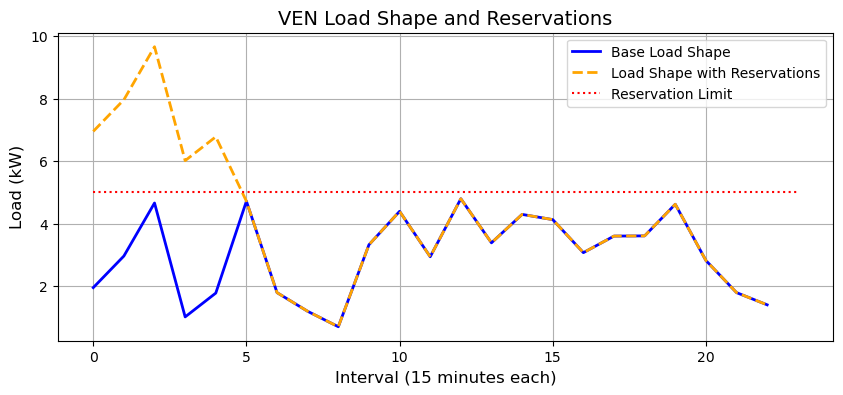

In [231]:
# 1 home 
for i in range(1,24):
    clear_output(wait=True) 
    plt.figure(figsize=(10, 4))
    plt.plot([i for i in range(i)], homes[0].base_load_shape[0:i], label="Base Load Shape", color="blue", linewidth=2)
    plt.plot([i for i in range(i)], homes[0].reservation_load_shape[0:i], label="Load Shape with Reservations", color="orange", linestyle="--", linewidth=2)
    plt.plot([i for i in range(24)], [homes[0].reservation_capacity for i in range(24)], color="red", linestyle=":", label="Reservation Limit")
    plt.title("VEN Load Shape and Reservations", fontsize=14)
    plt.xlabel("Interval (15 minutes each)", fontsize=12)
    plt.ylabel("Load (kW)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()
    
    # Pause to simulate processing time (optional)
    time.sleep(0.5)

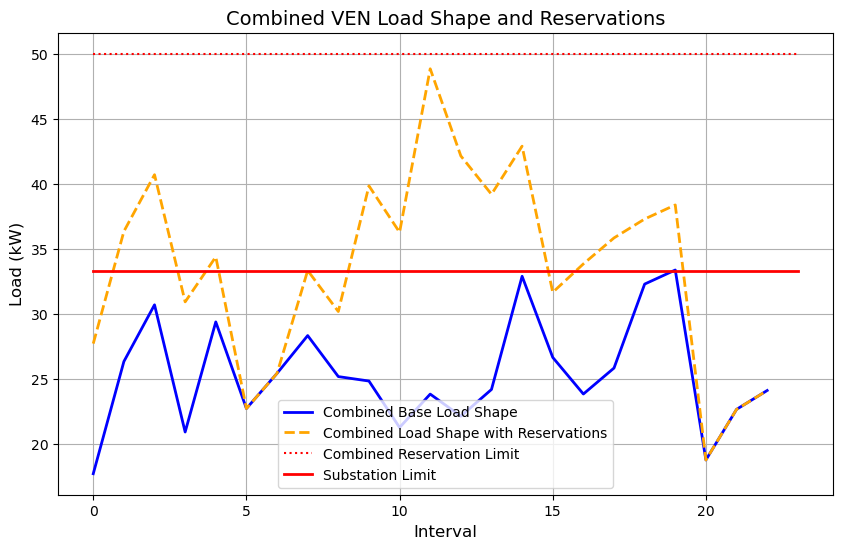

In [232]:
# all homes 
for i in range(1, 24):
    clear_output(wait=True)
# Calculate cumulative loads for all homes
    combined_base_load = [sum(home.base_load_shape[j] for home in homes.values()) for j in range(i)]
    combined_reservation_load = [sum(home.reservation_load_shape[j] for home in homes.values()) for j in range(i)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(i), combined_base_load, label="Combined Base Load Shape", color="blue", linewidth=2)
    plt.plot(range(i), combined_reservation_load, label="Combined Load Shape with Reservations", color="orange", linestyle="--", linewidth=2)
    # Plot reservation capacity line (assuming it's constant across intervals and homes)
    reservation_capacity_total = sum(home.reservation_capacity for home in homes.values())
    plt.plot(range(24), [reservation_capacity_total] * 24, color="red", linestyle=":", label="Combined Reservation Limit")
    plt.plot(range(24), [reservation_capacity_total*2/3] * 24, color="red", linewidth = '2', linestyle="solid", label="Substation Limit")
    
    # Add title and labels
    plt.title("Combined VEN Load Shape and Reservations", fontsize=14)
    plt.xlabel("Interval", fontsize=12)
    plt.ylabel("Load (kW)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()
    # Pause to simulate processing time (optional)
    time.sleep(0.5)

In [233]:
# scrap 
#     def post_capacity_subscription(self, program_id, event_id, resource_name, intervals, capacity_values):
#         """
#         Post a capacity subscription event to the REST API.
        
#         Args:
#         - program_id (str): The ID of the program.
#         - event_id (str): The event ID.
#         - self.client_name (str): The client name.
#         - resource_name (str): The resource name.
#         - intervals (list): List of intervals (start, duration).
#         - capacity_values (list): List of capacity values for each interval.
        
#         Returns:
#         - Response object from the POST request.
#         """
#         # Generate payload based on the capacity subscription format
#         intervals_payload = []
#         # Below if intervals need to be hourly
#         for i, interval in enumerate(intervals):
#             interval_payload = {
#                 "id": i,
#                 "payloads": [{
#                     "type": "CAPACITY_RESERVATION",
#                     "values": [interval[1]]
#                 }]
#             }
#             intervals_payload.append(interval_payload)

#         payload = {
#             "reportName": "capacitySubscriptionReport",
#             "programID": program_id,
#             "eventID": event_id,
#             "clientName": self.client_name,
#             "payloadDescriptors": [{
#                 "payloadType": "CAPACITY_RESERVATION",
#                 "units": "KWH"
#             }],
#             "resources": [{
#                 "resourceName": resource_name,
#                 "intervalPeriod": {
#                     "start": f"2024-11-13T{intervals[0]}:00:00.000Z",  # Start of the first interval
#                     "duration": "PT1H"  # Assuming 1 hour duration for each interval
#                 },
#                 "intervals": intervals_payload
#             }]
#         }
        
#         headers = {
#             "Content-Type": "application/json",
#             "Authorization": "Bearer ven_token"
#         }
        
#         try:
#             response = requests.post(f"{self.api_url}/capacity_subscription", json=payload, headers=headers)
            
#             if response.status_code == 200:
#                 print(f"Capacity subscription for program {program_id} successful.")
#             else:
#                 print(f"Error: {response.status_code} - {response.text}")
#             return response
#         except requests.exceptions.RequestException as e:
#             print(f"Error while posting capacity subscription: {e}")
#             return None